In [3]:
# Google Colabでkaggle.jsonをアップロード
from google.colab import files
files.upload()

{}

In [0]:
# Google Colabでkaggle.jsonをフォルダ移動
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [2]:
# Google Colabでデータセットをダウンロード
!pip install kaggle
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 51.5MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 26.8MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.91MB/s]


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

In [2]:
# data_folder = '../data/'  # Local環境
data_folder = ''    #Google Colab
train = pd.read_csv(data_folder + 'train.csv')
test_x = pd.read_csv(data_folder + 'test.csv')
test_y = pd.read_csv(data_folder + 'gender_submission.csv')
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [0]:
# 'Cabin"のデータはNanを0、それ以外を1に置き換える
def cabin_encode(data):
    data['Cabin'] = data['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)
    return data


# カテゴリ変数をLabel Encoding
def labeling(data, cat_cols):
    for cat in cat_cols:
        cat_i = data.columns.get_loc(cat)
        labels, _ = pd.factorize(data.iloc[:, cat_i])
        for i in range(len(labels)):
            data.iat[i, cat_i] = labels[i]

    return data


def standard(data, num_cols):
    # 数値データのNanを0に置き換える
    data[num_cols] = data[num_cols].fillna(0)
    # 数値データを正規化
    scaler = StandardScaler()
    data[num_cols] = scaler.fit_transform(data[num_cols])

    return data


ans_col = ['Survived']
cat_cols = ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
num_cols = list(set(train.columns) - set(ans_col + cat_cols))
train = cabin_encode(train)
train = labeling(train, cat_cols)
train = standard(train, num_cols)

cat_cols = ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
num_cols = list(set(test_x.columns) - set(cat_cols))
test_x = cabin_encode(test_x)
test_x = labeling(test_x, cat_cols)
test_x = standard(test_x, num_cols)

In [0]:
# IDと名前はユニークなデータなので削除
# Ticketはダブリが少ないので削除
del_cols = ['PassengerId', 'Name', 'Ticket']

# トレーニングデータを分割
x_cols = list(set(train.columns) - set(ans_col + del_cols))
train_x = train.drop(del_cols + ans_col, axis=1)
train_y = train.loc[:, ans_col]

# テストデータの必要のないカラムを削除
test_x = test_x.drop(del_cols, axis=1)
test_y = test_y.loc[:, ans_col]

# カテゴリ変数と正解データをOne Hot Encoding
cat_cols = list(set(cat_cols) - set(del_cols))
train_x = pd.get_dummies(train_x, columns=cat_cols)
train_y = pd.get_dummies(train_y, columns=ans_col)
test_x = pd.get_dummies(test_x, columns=cat_cols)

In [5]:
# トレインデータ確認
train_x

,Age,SibSp,Parch,Fare,Cabin_0,Cabin_1,Pclass_0,Pclass_1,Pclass_2,Embarked_-1,Embarked_0,Embarked_1,Embarked_2,Sex_0,Sex_1
0,-0.102313,0.432793,-0.473674,-0.502445,1,0,1,0,0,0,1,0,0,1,0
1,0.807492,0.432793,-0.473674,0.786845,0,1,0,1,0,0,0,1,0,0,1
2,0.125138,-0.474545,-0.473674,-0.488854,1,0,1,0,0,0,1,0,0,0,1
3,0.636903,0.432793,-0.473674,0.420730,0,1,0,1,0,0,1,0,0,0,1
4,0.636903,-0.474545,-0.473674,-0.486337,1,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.182001,-0.474545,-0.473674,-0.386671,1,0,0,0,1,0,1,0,0,1,0
887,-0.272901,-0.474545,-0.473674,-0.044381,0,1,0,1,0,0,1,0,0,0,1
888,-1.353294,0.432793,2.008933,-0.176263,1,0,1,0,0,0,1,0,0,0,1
889,0.125138,-0.474545,-0.473674,-0.044381,0,1,0,1,0,0,0,1,0,1,0


In [6]:
# テストデータ確認
test_x

,Age,SibSp,Parch,Fare,Cabin_0,Cabin_1,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2,Sex_0,Sex_1
0,0.594801,-0.499470,-0.400248,-0.496637,1,0,1,0,0,1,0,0,1,0
1,1.305896,0.616992,-0.400248,-0.511497,1,0,1,0,0,0,1,0,0,1
2,2.159209,-0.499470,-0.400248,-0.463335,1,0,0,1,0,1,0,0,1,0
3,0.168145,-0.499470,-0.400248,-0.481704,1,0,1,0,0,0,1,0,1,0
4,-0.116293,0.616992,0.619896,-0.416740,1,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,-1.367819,-0.499470,-0.400248,-0.492680,1,0,1,0,0,0,1,0,1,0
414,0.850795,-0.499470,-0.400248,1.314641,0,1,0,0,1,0,0,1,0,1
415,0.822352,-0.499470,-0.400248,-0.507017,1,0,1,0,0,0,1,0,1,0
416,-1.367819,-0.499470,-0.400248,-0.492680,1,0,1,0,0,0,1,0,1,0


In [0]:
# トレインデータに'Embarked_-1'があったので列を削除
train_x = train_x.drop('Embarked_-1', axis=1)

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.do1 = nn.Dropout2d(dropout_p)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.do2 = nn.Dropout2d(dropout_p)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = f.relu(self.do1(self.fc1(x)))
        x = f.relu(self.do2(self.fc2(x)))
        x = self.fc3(x)
        return x


def to_cuda(obj):
    if torch.cuda.is_available():
        return obj.cuda()
    return obj

In [0]:
input_size = len(train_x.columns)
outpu_size = len(train_y.columns)

train_x = torch.FloatTensor(np.array(train_x))
train_x = to_cuda(train_x)
train_y = torch.FloatTensor(np.array(train_y))
train_y = to_cuda(train_y)

In [14]:
HIDDEN_SIZE = 30
DROPOUT_P = 0.2
EPOCH_NUM = 500
BATCH_SIZE = 20

train = data.TensorDataset(train_x, train_y)
train_loader = data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

net = Net(input_size, HIDDEN_SIZE, outpu_size, DROPOUT_P)
net = to_cuda(net)
print(net)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

Net(
  (fc1): Linear(in_features=14, out_features=30, bias=True)
  (do1): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (do2): Dropout2d(p=0.2, inplace=False)
  (fc3): Linear(in_features=30, out_features=2, bias=True)
)


Epoch: 50 | Total Loss: 6
Epoch: 100 | Total Loss: 6
Epoch: 150 | Total Loss: 6
Epoch: 200 | Total Loss: 6
Epoch: 250 | Total Loss: 6
Epoch: 300 | Total Loss: 5
Epoch: 350 | Total Loss: 5
Epoch: 400 | Total Loss: 6
Epoch: 450 | Total Loss: 5
Epoch: 500 | Total Loss: 5


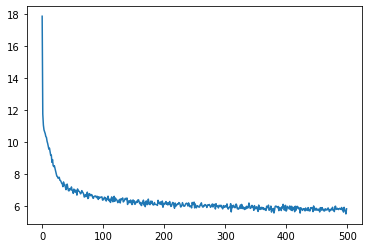

In [15]:
# 学習
totalloss_log = []
for e in range(EPOCH_NUM):
    total_loss = 0
    for x, y in train_loader:
        x, y = Variable(x), Variable(y)
        optimizer.zero_grad()
        output = net(x)

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    totalloss_log.append(total_loss)

    if (e + 1) % 50 == 0:
        print('Epoch: %d | Total Loss: %d' % (e + 1, total_loss))

plt.plot([i for i in range(len(totalloss_log))], totalloss_log)

In [0]:
test_x = torch.FloatTensor(np.array(test_x))
test_x = to_cuda(test_x)
test_y = torch.IntTensor(np.array(test_y))
test_y = to_cuda(test_y)
test_x, test_y = Variable(test_x), Variable(test_y)

In [17]:
net.eval()
result = torch.max(net(test_x).data, 1)[1]


def calc_accuracy(result, target):
    sum_correct = 0
    for r, t in zip(result, target):
        if r == t:
            sum_correct += 1

    return sum_correct / len(result) * 100.0


accuracy = calc_accuracy(result.numpy(), test_y.squeeze().data.numpy())
print('{}%'.format(accuracy))

92.58373205741627%
